## 20190312

【踩坑】

按照<https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter>，进行编写  
但Keras接口有变化，导致在卷积时通道顺序有问题  
记得编写完模型用`model.summary()`看一下

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import os
import tensorflow as tf
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

## Preparing the Data

- 原图像尺寸不一，更改图片尺寸至64x64x3 / 128x128x3
- 差值方法：共五种，感觉差别不是很大（高糊情况下）
  - https://blog.csdn.net/jningwei/article/details/78822026

In [3]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# 先用2000张做测试
#train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
#test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)  # ROWS, COLS是不是写反了
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T    #这块转置是为后面服务的？
        if i%1000 == 0:
            print('Processed {} of {}'.format(i, count))
            
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000
Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500
Train shape: (25000, 3, 64, 64)
Test shape: (12500, 3, 64, 64)


In [24]:
train_dogs

['./data/train/dog.5793.jpg',
 './data/train/dog.4089.jpg',
 './data/train/dog.9161.jpg',
 './data/train/dog.9269.jpg',
 './data/train/dog.10432.jpg',
 './data/train/dog.8113.jpg',
 './data/train/dog.10659.jpg',
 './data/train/dog.435.jpg',
 './data/train/dog.8630.jpg',
 './data/train/dog.1471.jpg',
 './data/train/dog.7539.jpg',
 './data/train/dog.9377.jpg',
 './data/train/dog.1408.jpg',
 './data/train/dog.11023.jpg',
 './data/train/dog.10363.jpg',
 './data/train/dog.2305.jpg',
 './data/train/dog.4636.jpg',
 './data/train/dog.8222.jpg',
 './data/train/dog.2541.jpg',
 './data/train/dog.2802.jpg',
 './data/train/dog.8903.jpg',
 './data/train/dog.4897.jpg',
 './data/train/dog.7175.jpg',
 './data/train/dog.2814.jpg',
 './data/train/dog.9511.jpg',
 './data/train/dog.7006.jpg',
 './data/train/dog.684.jpg',
 './data/train/dog.4842.jpg',
 './data/train/dog.9594.jpg',
 './data/train/dog.8963.jpg',
 './data/train/dog.10544.jpg',
 './data/train/dog.5174.jpg',
 './data/train/dog.1253.jpg',
 './dat

Text(0.5, 1.0, 'dogs and cats')

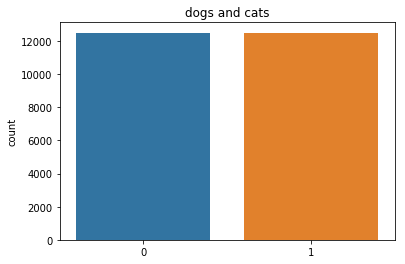

In [4]:
# 查看数据是否平衡
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
sns.countplot(labels)
plt.title('dogs and cats')

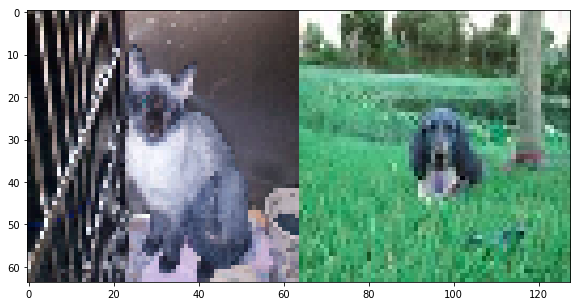

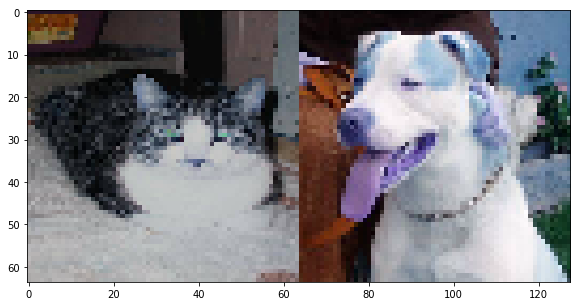

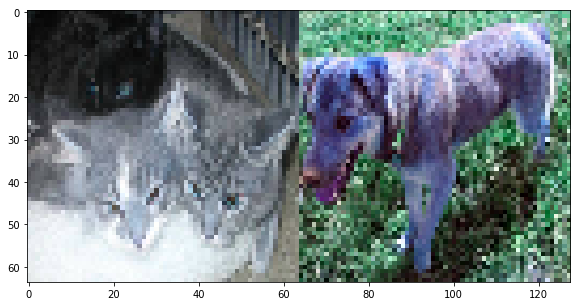

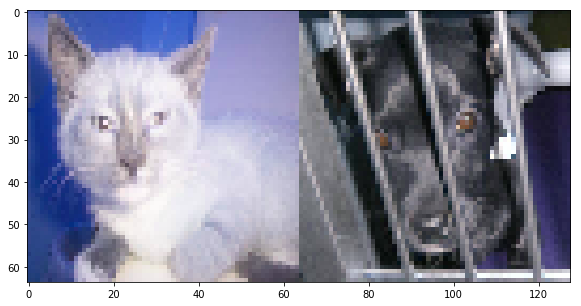

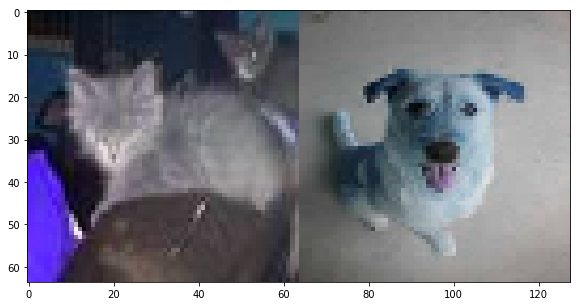

In [5]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

## CatdogNet-16

- 基于VGG-16
- 优化器使用 RMSprop
- channel在前的时候，maxpooling要加对应的参数

In [6]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape = (3, ROWS, COLS)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    MaxPooling2D(pool_size=(2, 2), data_format="channels_first")
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    MaxPooling2D(pool_size=(2, 2), data_format="channels_first")
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    MaxPooling2D(pool_size=(2, 2), data_format="channels_first")
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    MaxPooling2D(pool_size=(2, 2), data_format="channels_first")
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    MaxPooling2D(pool_size=(2, 2), data_format="channels_first")
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    '''
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    '''
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()


## Train and Predict

- 交叉验证集的loss不再下降的时候停止训练，防止过拟合

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 20
batch_size = 128

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
#early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1)  # verbose是信息展示模式

def run_catdog():
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs, validation_split=0.15, 
              verbose=1, shuffle=True, callbacks=[history, learning_rate_reduction])
    
    predictions = model.predict(test, verbose=1)
    return predictions, history

predictions, history = run_catdog()

Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 34s 2ms/step - loss: 0.7328 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5003
Epoch 2/20
21250/21250 [==============================] - 32s 1ms/step - loss: 0.6935 - acc: 0.5243 - val_loss: 0.7572 - val_acc: 0.5213
Epoch 3/20
21250/21250 [==============================] - 32s 1ms/step - loss: 0.6693 - acc: 0.5993 - val_loss: 0.7139 - val_acc: 0.6360
Epoch 4/20
21250/21250 [==============================] - 31s 1ms/step - loss: 0.6446 - acc: 0.6336 - val_loss: 0.6570 - val_acc: 0.5973
Epoch 5/20
21250/21250 [==============================] - 31s 1ms/step - loss: 0.6236 - acc: 0.6574 - val_loss: 0.8480 - val_acc: 0.5821
Epoch 6/20
21250/21250 [==============================] - 31s 1ms/step - loss: 0.6058 - acc: 0.6752 - val_loss: 0.6281 - val_acc: 0.6245
Epoch 7/20
21250/21250 [==============================] - 31s 1ms/step - loss: 0.5912 - acc: 0.6855 - val_loss: 1.1551 - val_acc:

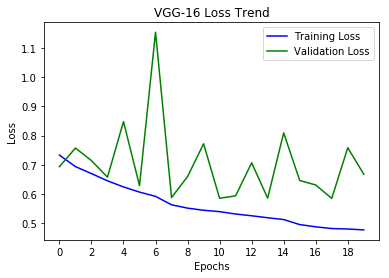

In [8]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

I am 73.74% sure this is a Cat


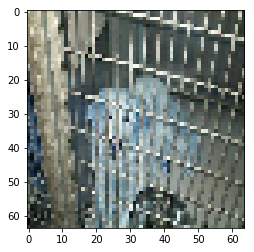

I am 91.85% sure this is a Dog


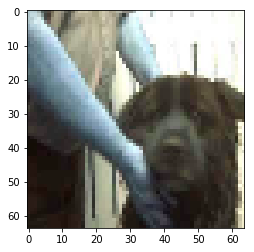

I am 53.05% sure this is a Dog


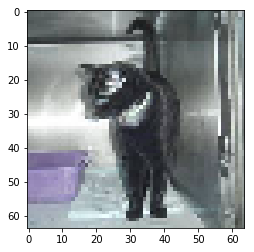

I am 79.48% sure this is a Dog


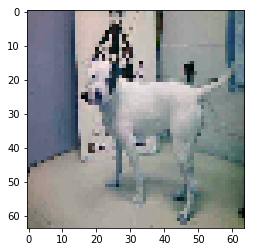

I am 78.15% sure this is a Cat


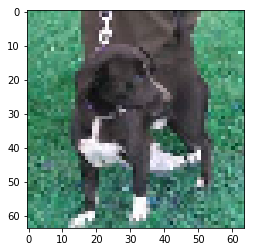

I am 83.66% sure this is a Dog


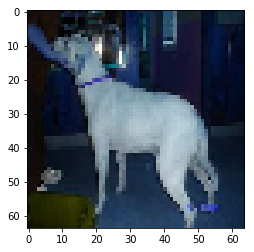

I am 59.83% sure this is a Dog


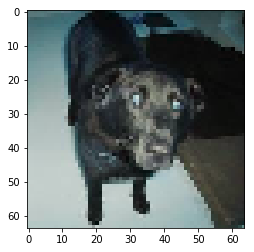

I am 87.51% sure this is a Dog


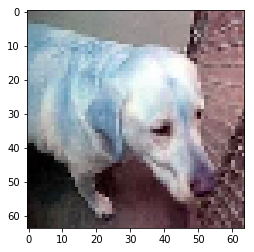

I am 79.69% sure this is a Cat


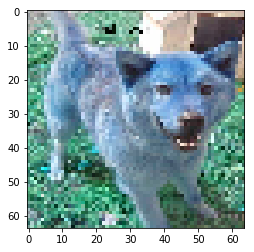

I am 80.31% sure this is a Dog


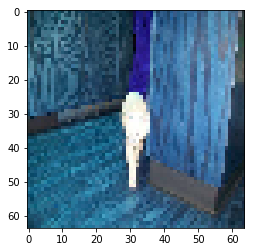

In [9]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

In [11]:
predictions.shape

(12500, 1)

In [21]:
1 - predictions

array([[0.7373525 ],
       [0.08145303],
       [0.469454  ],
       ...,
       [0.28489828],
       [0.1116631 ],
       [0.20414394]], dtype=float32)

In [23]:
# select the indix with the maximum probability
#results = np.around(predictions).reshape(-1)

#results = np.argmax(predictions, axis = 1)

results = (1-predictions).reshape(-1)

results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1,12501),name = "id"),results],axis = 1)

submission.to_csv("vgg16_result.csv",index=False)